
# Background
COVID-19 is caused by a coronavirus called SARS-CoV-2. Older adults and people who have severe underlying medical conditions like heart or lung disease or diabetes seem to be at higher risk for developing more serious complications from COVID-19 illness.  
In 2020, COVID-19 outbroke severely in the whole world. New York City is one of the most affected areas. Up to date, there are 6,226,409 confirmed cases worldwide, 1,835,300 of them are in the United State, while New York City itself has 203,303 confirmed cases.


# Problem

In this project, we will explore insights and interesting information about the correlation between location data and COVID-19 data by neighborhoods in New York City, to see how they affect each other. 



# Data


### data-zsnEP.csv
This dataset includes the Cases, Cases per 100,000, Deaths per 100,000 and Percent of people tested who tested positive of Covid-19 by zip code within New York City. 

Source:[NYC Health] https://www1.nyc.gov/site/doh/covid/covid-19-data.page



### Foursquare API
Based on the zip code, cooridinates of the areas and venues within 500 meters are collected through Foursquare API, including venue name, venue Latitude, venue Longitude and venue category.

<br>

<br>
Code used to read and collectdata is below 


In [262]:
# import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import folium 
import requests

In [5]:
# load coronavirus data
covi_df = pd.read_csv('data-zsnEP.csv')
covi_df.head()

,ZIP,Neighborhood,Borough,Cases,"Cases per 100,000","Deaths per 100,000",Percent of people tested who tested positive
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,361,1532.06,89.12,17.38
1,10002,Chinatown/Lower East Side,Manhattan,1035,1348.44,188.91,23.88
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,445,827.11,59.48,14.23
3,10004,Financial District,Manhattan,31,849.17,27.39,14.69
4,10005,Financial District,Manhattan,61,726.53,23.82,12.45


In [45]:
# Foursquare information
CLIENT_ID = 'AHEDMVAJIUDVUSPU1MANS5NFCQT5LKEYRP05GGJR5X0QEY0P' 
CLIENT_SECRET = 'XSSELRMELFJWGJJRKT4U4RQC45OVHADU1NX22PIOA3L0EBB0' 
VERSION = '20200304'

In [46]:
# get the coordinates from zip codes
covi_df['latitude']=None
covi_df['longitude']=None

for i in range(len(covi_df)):
    location = geolocator.geocode(str(covi_df.ZIP[i])+',US')
    covi_df['latitude'][i] = location.latitude
    covi_df['longitude'][i] = location.longitude

C:\Users\40463\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\40463\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [51]:
covi_df.head()

,ZIP,Neighborhood,Borough,Cases,"Cases per 100,000","Deaths per 100,000",Percent of people tested who tested positive,latitude,longitude
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,361,1532.06,89.12,17.38,40.7506,-73.998
1,10002,Chinatown/Lower East Side,Manhattan,1035,1348.44,188.91,23.88,40.7223,-73.9877
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,445,827.11,59.48,14.23,40.7316,-73.9885
3,10004,Financial District,Manhattan,31,849.17,27.39,14.69,40.7007,-74.0135
4,10005,Financial District,Manhattan,61,726.53,23.82,12.45,40.7056,-74.0089


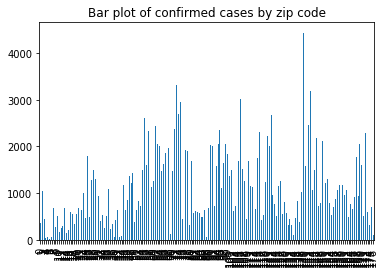

In [67]:
# data visualization
covi_df['Cases'].plot(kind='bar',title='Bar plot of confirmed cases by zip code')

You can see from the bar plot above that the numbers of confirmed case are sparse. Some neighborhoods has obvious a lot more cases than the other ones.

In [127]:
# Choropleth maps
df1=pd.DataFrame(covi_df.Neighborhood.str.split('/').tolist()).stack().to_frame()
df1.columns=['neighborhood']
df1=pd.DataFrame(df1.to_records()).drop('level_1',axis=1)
df2=pd.merge(covi_df.reset_index(), df1, left_on='index',right_on='level_0',how='right').drop(['index','Neighborhood','level_0'],axis=1)
df2.rename(columns={'neighborhood':'Neighborhood'},inplace=True)

district_geo='https://data.beta.nyc/dataset/0ff93d2d-90ba-457c-9f7e-39e47bf2ac5f/resource/35dd04fb-81b3-479b-a074-a27a37888ce7/download/d085e2f8d0b54d4590b1e7d1f35594c1pediacitiesnycneighborhoods.geojson'

ny_map = folium.Map(location=[40.7128,-74.0060],zoom_start=15)
ny_map.choropleth(geo_data = district_geo,
                  name='choropleth',
              data = df2,
              columns = ['Neighborhood', 'Cases'],
              key_on = 'feature.properties.neighborhood',
              fill_color = 'YlOrRd', 
              fill_opacity = 0.7, 
              line_opacity = 0.2,
              legend_name = 'Cases')
               
folium.LayerControl().add_to(ny_map)
ny_map



C:\Users\40463\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [63]:
# get the nearby stores categories

def getNearbyVenues(postalcode,latitudes, longitudes, radius=500, LIMIT=30):
    
    venues_list=[]
    for code,lat, lng in zip(postalcode,latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([( 
            code,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZIP',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

df_venues = getNearbyVenues(postalcode=covi_df['ZIP'],latitudes=covi_df['latitude'],longitudes=covi_df['longitude'])

In [103]:
df_venues.head()

,ZIP,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10001,Bluestone Lane,40.752068,-73.998848,Coffee Shop
1,10001,New York Pizza Suprema,40.750124,-73.994992,Pizza Place
2,10001,You Should Be Dancing…..! / Club 412,40.750306,-73.994743,Dance Studio
3,10001,B&H Photo Video,40.753277,-73.996470,Camera Store
4,10001,Music Choice,40.752632,-73.994585,Music Venue


In [102]:
#save data
#df_venues.to_csv('Newyork_venues.csv')
#covi_df.to_csv('Covid_ny_co.csv')

In [140]:
df_venues.groupby(by='ZIP').count()

,Venue,Venue Latitude,Venue Longitude,Venue Category
ZIP,,,,
10001,30,30,30,30
10002,30,30,30,30
10003,30,30,30,30
10004,29,29,29,29
10005,30,30,30,30
...,...,...,...,...
11691,6,6,6,6
11692,19,19,19,19
11693,6,6,6,6


Since df_venues has 176 rows while covid_df has 177 rows, we can tell one row is missing. Therefore we need to manually find it and update the information. 

In [151]:
pd.merge(df_venues.groupby(by='ZIP').count(),covi_df,how='right',on='ZIP').tail(2)

,ZIP,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighborhood,Borough,Cases,"Cases per 100,000","Deaths per 100,000",Percent of people tested who tested positive,latitude,longitude
175,11697,11.0,11.0,11.0,11.0,Breezy Point,Queens,107,3025.43,84.83,9.70,40.5597,-73.915
176,11234,NaN,NaN,NaN,NaN,Bergen Beach/Flatlands/Marine Park/Mill Basin,Brooklyn,2216,2325.17,185.72,30.27,40.5869,-73.882


It seems like the latitude and longitude from Geopy was misleading, which casued an empty result from Foursquare. After updating the coordinates into the one on Google, the information was successful updated. Part of the code was hidden.

In [162]:
# update #11234
df_venues=pd.concat([df_venues,nearby_venues])
# update coordinates 
covi_df.loc[covi_df['ZIP']==11234,['latitude','longitude']]=[40.6008,-73.9066]

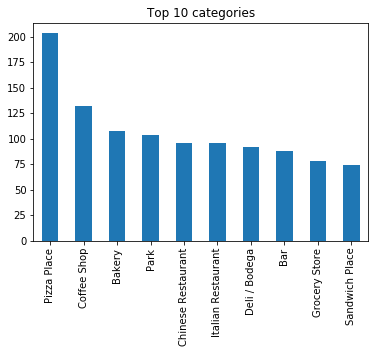

In [163]:
df_venues['Venue Category'].value_counts().head(10).plot(kind='bar',title='Top 10 categories')

In [180]:
# one hot encoding flatten the category, make one zipcode per row

# one hot encoding
data_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add ZIP column back to dataframe
data_onehot['ZIP'] = df_venues['ZIP'] 

# move ZIP column to the first column
fixed_columns = [data_onehot.columns[-1]] + list(data_onehot.columns[:-1])
data_onehot = data_onehot[fixed_columns]

mer_df=pd.merge(data_onehot.groupby(by='ZIP').sum(),covi_df,how='right',on='ZIP').drop(['latitude','longitude','Neighborhood_y','Borough'],axis=1)

In [185]:
print(mer_df.shape)
mer_df.head(3)

(177, 349)


,ZIP,Accessories Store,Adult Boutique,African Restaurant,Airport Tram,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Cases,"Cases per 100,000","Deaths per 100,000",Percent of people tested who tested positive
0,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,361,1532.06,89.12,17.38
1,10002,0,0,0,0,1,0,0,0,0,...,0,2,0,0,0,0,1035,1348.44,188.91,23.88
2,10003,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,445,827.11,59.48,14.23


The final data is 177*349, including Zipcode, 344 one hot coding categories and 4 columns of Covid cases data.

# Methodology 
First linear regression is used to prove if there is any linear relationship between the categories and number of cases. 344 one hot coding categorie as predictors, X, while "Cases" as the target variable. However, since the predictors are either 0 or 1, the numbers of "Cases" are much higher, therefore we would take a log transformation on "Cases" to balance the data.

Adding Random Forest as a more complicated algorithms to see if any difference. 

Since the feature dimension is a lot higher than the number of observations PCA is applied to reduce dementions. Then use Kmeans to cluster


In [192]:
# data transformation
X=mer_df.iloc[:,1:345]
y=np.log(mer_df['Cases'])

In [334]:
from sklearn.linear_model import LinearRegression
lm=LinearRegression().fit(X,y)
coef=pd.DataFrame(X.columns,list(lm.coef_)).reset_index()
coef.columns=['Coeffiencts','Category']
coef.sort_values(by='Coeffiencts',ascending=False).head(5)

,Coeffiencts,Category
12,1.725480,Art Museum
89,1.696269,Department Store
66,1.655098,Cheese Shop
123,1.641648,Fried Chicken Joint
100,1.485366,Dumpling Restaurant


In [332]:
coef.sort_values(by='Coeffiencts',ascending=False).tail(5)

,Coeffiencts,Category
195,-1.132608,Mediterranean Restaurant
78,-1.196123,Community Center
194,-1.261439,Mattress Store
41,-1.425798,Border Crossing
96,-2.392710,Dog Run


The dataframe above is the top 5 most important features, also known as category, from Linear regression result. "Dumpling Restaurant", "Cheese Shop", "Department Store", "Malay Restaurant" and "Motorcycle Shop" have the highest positive effect on the number of cases. 

In [333]:
from sklearn.ensemble import RandomForestRegressor
tree=RandomForestRegressor().fit(X,y)
impo=pd.DataFrame(X.columns,list(tree.feature_importances_)).reset_index()
impo.columns=['Importance','Category']
impo.sort_values(by='Importance',ascending=False).head(10)

,Importance,Category
202,0.195736,Monument / Landmark
96,0.054955,Dog Run
227,0.052345,Park
86,0.028971,Cycle Studio
169,0.028491,Italian Restaurant
41,0.026117,Border Crossing
72,0.021546,Coffee Shop
4,0.018978,American Restaurant
240,0.018798,Pizza Place
238,0.014924,Pier


In [269]:
# PCA
from sklearn.decomposition import PCA
pca=PCA()
X_pca = pca.fit_transform(X)

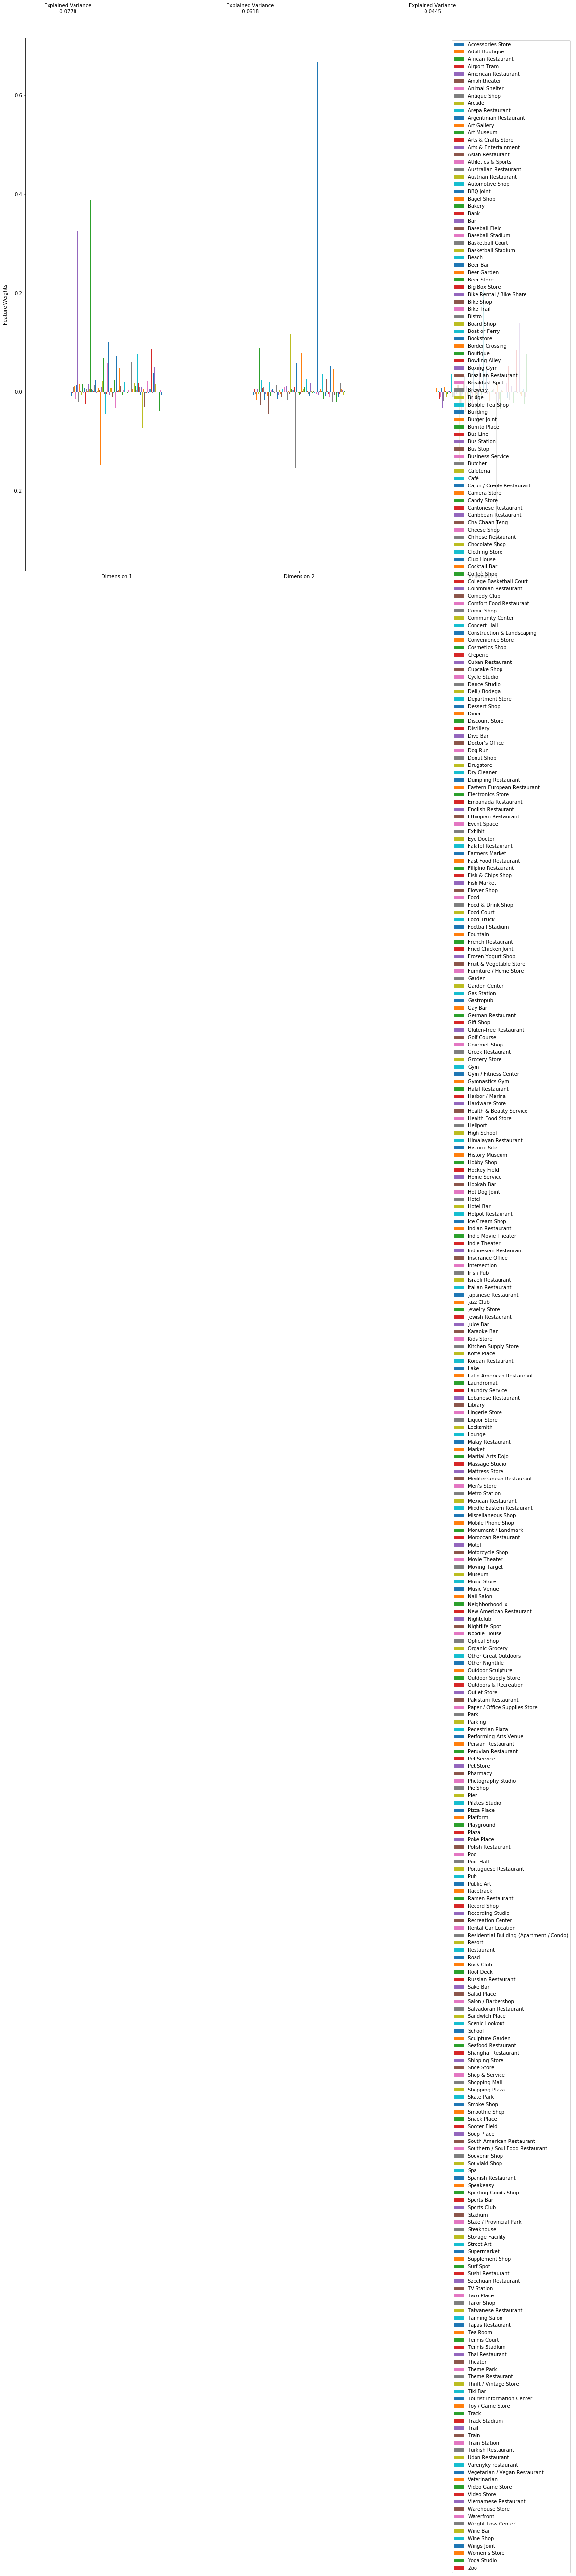

In [268]:
def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (20,20))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))


pca_results(X,pca)

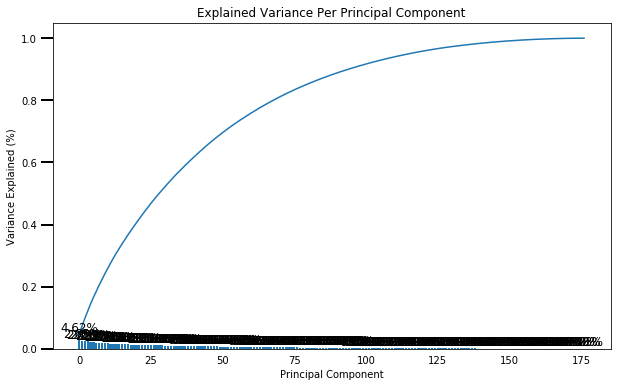

In [270]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

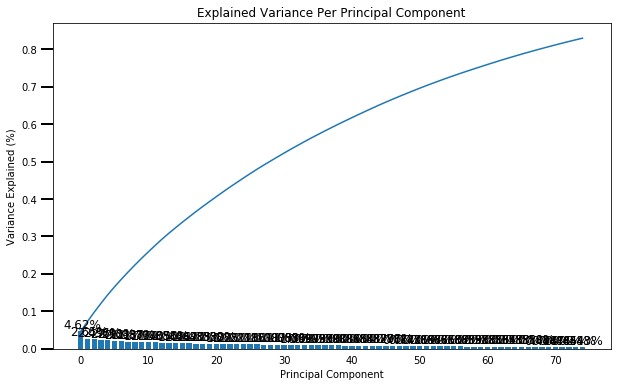

In [275]:
pca2=PCA(n_components=75)
X_pca2 = pca2.fit_transform(X)
scree_plot(pca2)

We picked 75 components for the PCA model since it is the thredsold for 80% explained variance.

In [283]:
# refit linear regression
lm2=LinearRegression().fit(X_pca2,y)
coef2=pd.DataFrame(list(lm2.coef_)).reset_index()
coef2.columns=['index','Coef']
coef2.sort_values(by='Coef',ascending=False).head(5)

,index,Coef
67,67,0.777131
34,34,0.401492
70,70,0.395104
56,56,0.386636
42,42,0.320180


In [286]:
result2=pd.DataFrame(pca2.components_[[67,34,70,56,42]])
result2

,0,1,2,3,4,5,6,7,8,9,...,334,335,336,337,338,339,340,341,342,343
0,0.100716,0.048448,0.003593,-0.058275,-0.106715,-0.027541,-0.027470,0.027802,0.038790,-0.063882,...,-0.043132,-0.003411,0.063088,0.010193,0.031887,-0.078381,-0.001371,0.003635,-0.031128,0.005508
1,-0.005439,-0.010162,0.032294,0.009112,-0.056510,0.042252,0.061888,-0.026095,0.004504,0.058613,...,0.012223,0.000447,0.053472,-0.013354,0.024352,-0.036784,0.030431,0.137350,0.024531,0.012028
2,0.046427,0.041391,0.104975,0.046878,-0.056036,0.049171,-0.021675,-0.007942,0.008892,0.057261,...,0.026299,0.002409,-0.038924,0.024838,0.096274,-0.037427,-0.002777,-0.055061,-0.076374,0.036503
3,0.001658,-0.010144,-0.041984,0.056967,-0.031576,-0.032408,0.056904,-0.057477,-0.016806,-0.051923,...,-0.003231,0.004738,0.036826,-0.004822,-0.070996,0.153051,-0.002025,-0.147376,-0.026614,0.017355
4,-0.066823,0.080807,0.032359,-0.041439,-0.032605,0.023102,0.049735,-0.025624,-0.036048,0.009703,...,-0.008947,0.020044,0.023078,-0.034137,-0.103700,0.052512,0.014616,0.042939,-0.005817,-0.016231


In [354]:
from sklearn.cluster import KMeans
kmeans =  KMeans(n_clusters=3,random_state=0)
kmeans.fit(X_pca2)
result3=pd.DataFrame(kmeans.labels_,columns=['label'])
result3['Cases']=covi_df['Cases']

In [342]:
result4=result3.groupby(by='label').count()

In [344]:
# groupby label to see if there is any trend on the cases
result4['Mean']=result3.groupby(by='label').mean()
result4.columns=['Count', 'Mean']

In [348]:
result4

,Count,Mean
label,,
0,14,1351.785714
1,101,1268.247525
2,62,762.048387


In [355]:
merged=pd.concat([covi_df,result3['label']], axis=1)


In [356]:
# create map
map_clusters = folium.Map(location=[40.7128,-74.0060], zoom_start=11)

kclusters=3
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['latitude'], merged['longitude'], merged['Neighborhood'], merged['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters